# Autoencoder simple

# Autoencoder simple

In [1]:
# import
import os
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from ctapipe.visualization import CameraDisplay
from ctapipe.instrument.camera import CameraGeometry
from ctapipe.io import EventSource 

import matplotlib.pyplot as plt
import random
import h5py
import time
import sys

sys.path.append(os.path.abspath("../.."))
from utils import evaluate_threshold_classifier, plot_error_histograms, clean_image_improvement, plot_cost_curves

import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

proton_path = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/test/protons_diffuse/zenith_20deg"

file_list = glob.glob(os.path.join(proton_path, "*.h5"))
with EventSource(file_list[0]) as source:
    for i, event in enumerate(source):
        for tel_id, tel_event in event.dl1.tel.items():
            geo = source.subarray.tel[tel_id].camera.geometry
        break

neighbors = geo.neighbors

class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )
    
        self.decoder = nn.Sequential(

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def load_model(model_path):
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Créer le modèle avec la bonne dimension
    model = AE(input_dim=1296)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Epochs d'entraînement: {checkpoint['epochs']}")
    print(f"Loss finale (train): {checkpoint['train_loss_history'][-1]:.6f}")
    print(f"Loss finale (val): {checkpoint['val_loss_history'][-1]:.6f}")
    
    return model, checkpoint


timestamp = "20260119_120354"

model_path = f"autoencoder_{timestamp}.pth"
csv_protons_path = f"errors_protons_{timestamp}.csv"
csv_protons_energy_path = f"energies_protons_{timestamp}.csv"
csv_gammas_path = f"errors_gammas_{timestamp}.csv"
csv_gammas_energy_path = f"energies_gammas_{timestamp}.csv"

model, checkpoint = load_model(model_path)

Using device: cpu


Table /r1/event/telescope/tel_001 is missing column first_cell_id for field first_cell_id of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_001 is missing column module_hires_local_clock_counter for field module_hires_local_clock_counter of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_001 is missing column pedestal_intensity for field pedestal_intensity of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_001 is missing column calibration_monitoring_id for field calibration_monitoring_id of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.


Modèle chargé depuis: autoencoder_20260119_120354.pth
Epochs d'entraînement: 10
Loss finale (train): 0.028382
Loss finale (val): 0.028769


In [3]:
def load_data(folder_path, max_events=None):
    telescopes = ["tel_001", "tel_002"]
    images_list = []
    masks_list = []
    peaks_list = []
    true_energy_list = []

    file_list = glob.glob(os.path.join(folder_path, "*.h5"))
    random.seed(42)
    random.shuffle(file_list)
    print(f"Found {len(file_list)} files", flush=True)

    for file_idx, file_path in enumerate(file_list, 1):
        print(f"Processing file {file_idx}/{len(file_list)}", flush=True)
        with h5py.File(file_path, "r") as f:
            
            ds_energy = f["simulation/event/subarray/shower"][:]
            energy_by_event = {
                row["event_id"]: row["true_energy"]
                for row in ds_energy
            }

            for tel in telescopes:
                ds_image = f[f"dl1/event/telescope/images/{tel}"][:]
                ds_params = f[f"dl1/event/telescope/parameters/{tel}"][:]

                n_events = ds_image.shape[0]

                for i in range(n_events):

                    if np.isnan(ds_params[i]["hillas_intensity"]):
                        continue

                    event_id = ds_params[i]["event_id"]
                    true_energy = energy_by_event[event_id]

                    images_list.append(ds_image[i]["image"].astype(np.float32))
                    peaks_list.append(ds_image[i]["peak_time"].astype(np.float32))
                    masks_list.append(ds_image[i]["image_mask"].astype(bool))
                    true_energy_list.append(true_energy.astype(np.float32))

                    if max_events is not None and len(images_list) >= max_events:
                        return images_list, masks_list, peaks_list, true_energy_list

    return images_list, masks_list, peaks_list, true_energy_list

class TelescopeDataset(Dataset):
    def __init__(self, folder_path, max_events=None):

        self.folder_path = folder_path
        self.images = []
        self.masks = []
        self.originals = []
        self.true_energies = []

        start_total = time.time()
        images, masks, peaks, true_energies = load_data(folder_path, max_events=max_events)
        self.true_energies = true_energies
        print(f"Loaded {len(images)} events.", flush=True)
        print("Applying preprocessing...", flush=True)

        self._build_dataset(images, masks, peaks)

        end_total = time.time()
        print(f"Total loading time: {end_total - start_total:.2f} seconds", flush=True)
        print(f"Total events loaded: {len(self.images)}", flush=True)

        self.image_shape = self.images[0].shape

    def _build_dataset(self, images, masks, peaks):
        for image, msk, pk in zip(images, masks, peaks):

            new_mask = clean_image_improvement(pk, msk, neighbors, max_diff=5)
            # Preprocess the image
            img = np.clip(image, 0, 1000)
            img = img * new_mask
            img = np.log1p(img)

            self.images.append(img)
            self.masks.append(new_mask)

            self.originals.append(image)
    
    def get_true_energies(self):
        return self.true_energies

    def get_originals(self):
        return self.originals
                                                          
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.masks[idx], dtype=torch.float32)

In [4]:
epochs = checkpoint['epochs']
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']

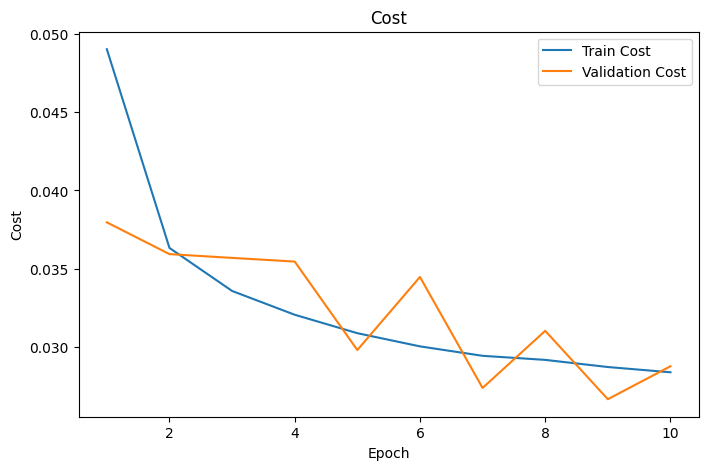

In [5]:
plot_cost_curves(train_loss_history, val_loss_history, epochs)

In [6]:
df_protons = pd.read_csv(csv_protons_path)
df_gammas = pd.read_csv(csv_gammas_path)
df_protons_energy = pd.read_csv(csv_protons_energy_path)
df_gammas_energy = pd.read_csv(csv_gammas_energy_path)

err_protons = df_protons["error"].to_numpy()
err_gammas = df_gammas["error"].to_numpy()
energy_protons = df_protons_energy["true_energy"].to_numpy()
energy_gammas = df_gammas_energy["true_energy"].to_numpy()

print("MSE protons:", np.median(err_protons))
print("MSE gammas:", np.median(err_gammas))

MSE protons: 0.36995745
MSE gammas: 0.463682975


Protons:
  Mean   = 0.389761
  Median = 0.369957
  Std    = 0.115890

Gammas:
  Mean   = 0.500620
  Median = 0.463683
  Std    = 0.174979



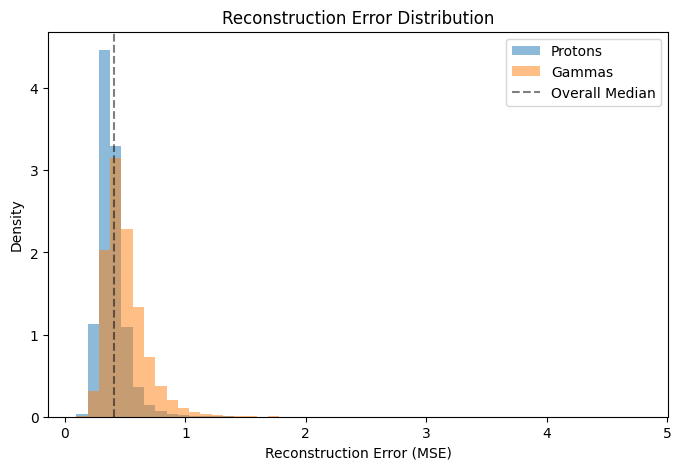

Using threshold: 0.4168202125


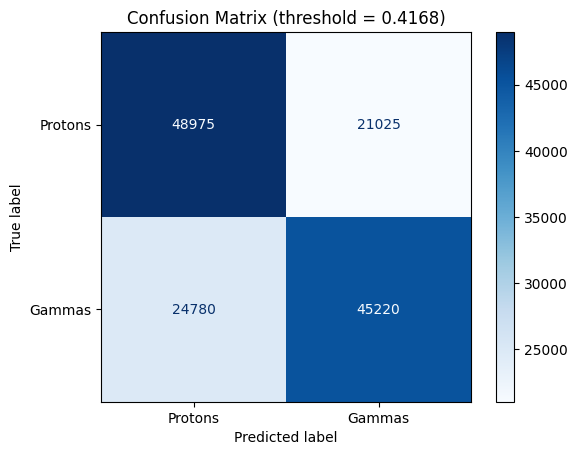


Classification Report:
              precision    recall  f1-score   support

     Protons       0.66      0.70      0.68     70000
      Gammas       0.68      0.65      0.66     70000

    accuracy                           0.67    140000
   macro avg       0.67      0.67      0.67    140000
weighted avg       0.67      0.67      0.67    140000



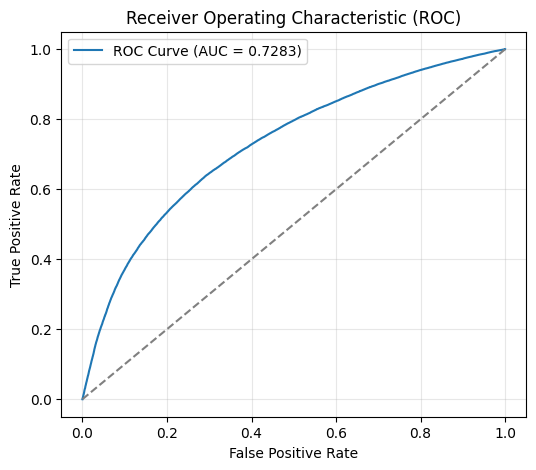

In [7]:
plot_error_histograms(err_protons, err_gammas)

threshold = (np.median(err_protons) + np.median(err_gammas)) / 2

y_true, y_pred, cm = evaluate_threshold_classifier(err_protons, err_gammas, threshold)

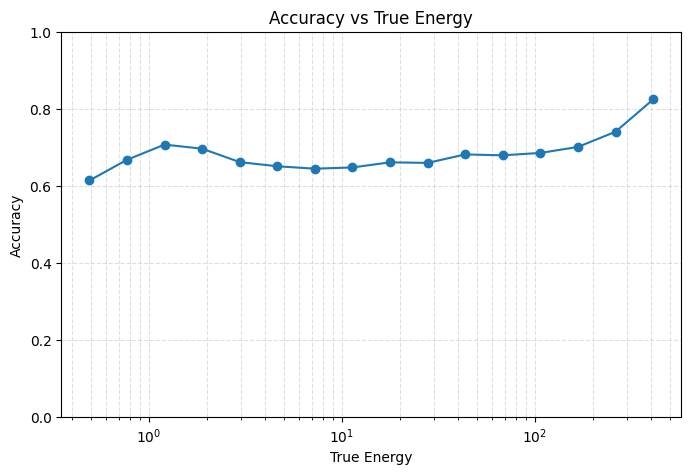

In [8]:
y_true_energy = np.concatenate([energy_protons, energy_gammas])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
energies = np.array(y_true_energy)

bins = np.logspace(np.log10(energies.min()), np.log10(energies.max()), 20)
bin_indices = np.digitize(energies, bins)

accuracies = []
bin_centers = []

MIN_EVENTS = 500

for b in range(1, len(bins)):
    idx = bin_indices == b
    n_events = idx.sum()

    if n_events < MIN_EVENTS:
        continue

    acc = np.mean(y_true[idx] == y_pred[idx])
    accuracies.append(acc)
    bin_centers.append((bins[b] + bins[b-1]) / 2)

plt.figure(figsize=(8,5))
plt.plot(bin_centers, accuracies, marker="o")
plt.xscale("log")
plt.xlabel("True Energy")
plt.ylabel("Accuracy")
plt.title("Accuracy vs True Energy")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.ylim(0, 1)
plt.show()


In [9]:
def reconstruct_dataset(model, dataset, batch_size=16):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    originals = []
    normalized = []
    reconstructed = []
    masks_all = []

    with torch.no_grad():
        for images, masks in dataloader:   
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            normalized.append(images.cpu())
            reconstructed.append(outputs.cpu())
            masks_all.append(masks.cpu())

    originals = dataset.get_originals()
    normalized = torch.cat(normalized, dim=0)
    reconstructed = torch.cat(reconstructed, dim=0)
    masks_all = torch.cat(masks_all, dim=0)

    return originals, normalized, reconstructed, masks_all

In [10]:
# Protons
path_protons = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/test/protons_diffuse/zenith_20deg"
dataset_protons = TelescopeDataset(path_protons, max_events=1500)
original_protons, norm_protons, rec_protons, masks_protons = reconstruct_dataset(model, dataset_protons)

# Gammas
path_gammas = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/test/gammas_diffuse/zenith_20deg"
dataset_gammas = TelescopeDataset(path_gammas, max_events=1500)
original_gammas, norm_gammas, rec_gammas, masks_gammas = reconstruct_dataset(model, dataset_gammas)

Found 5 files
Processing file 1/5


Processing file 2/5
Processing file 3/5
Loaded 1500 events.
Applying preprocessing...
Total loading time: 1.35 seconds
Total events loaded: 1500
Found 5 files
Processing file 1/5
Processing file 2/5
Processing file 3/5
Processing file 4/5
Processing file 5/5
Loaded 1500 events.
Applying preprocessing...
Total loading time: 1.02 seconds
Total events loaded: 1500


In [11]:
def display_reconstruction(orignal_norm, reconstructed_image, original_image, geometry):
    vmin = 0
    vmax = max(orignal_norm.max(), reconstructed_image.max())

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    disp0 = CameraDisplay(geometry, ax=axes[0, 0], title="Original Raw Image", image=original_image, cmap='viridis')
    disp0.add_colorbar(label="Photoelectrons (p.e.)")
    axes[0, 1].remove()


    disp1 = CameraDisplay(geometry, ax=axes[1, 0], title="Normalized + Masked Image", image=orignal_norm, cmap='viridis')
    disp1.set_limits_minmax(vmin, vmax)
    disp1.add_colorbar(label="Photoelectrons (p.e.)")

    disp2 = CameraDisplay(geometry, ax=axes[1, 1], title="Reconstructed Image (Flat AE)", image=reconstructed_image, cmap='viridis')
    disp2.set_limits_minmax(vmin, vmax)
    disp2.add_colorbar(label="Photoelectrons (p.e.)")

    plt.show()

    print("Image min (original):", orignal_norm.min(), "max:", orignal_norm.max())
    print("Image min (reconstructed):", reconstructed_image.min(), "max:", reconstructed_image.max())

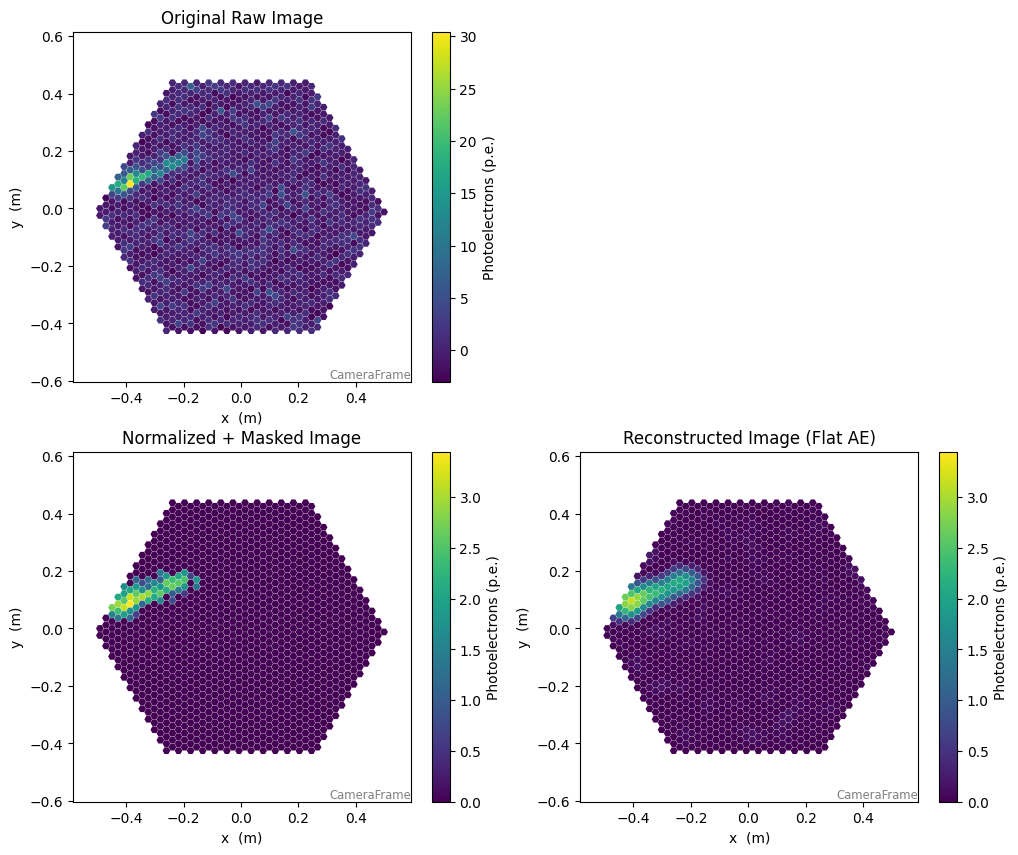

Image min (original): tensor(0.) max: tensor(3.4477)
Image min (reconstructed): tensor(-0.2221) max: tensor(3.1276)


In [12]:
idx = 9

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

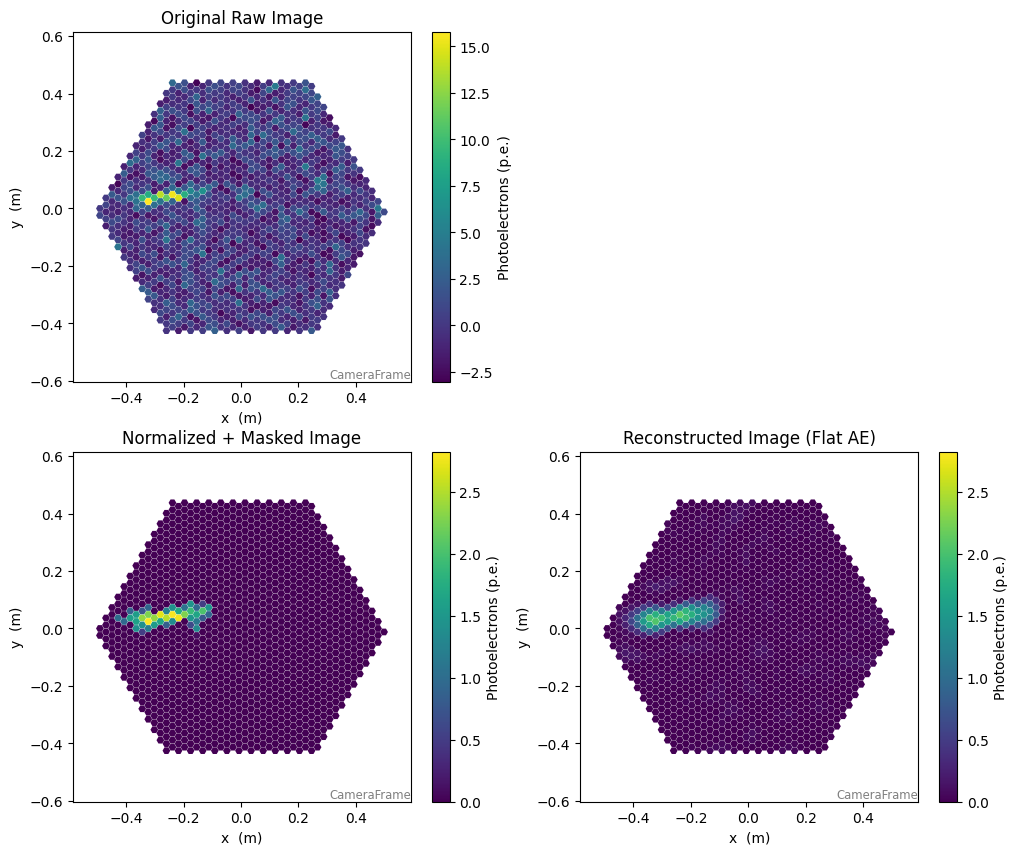

Image min (original): tensor(0.) max: tensor(2.8210)
Image min (reconstructed): tensor(-0.2681) max: tensor(2.0886)


In [13]:
idx = 3

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

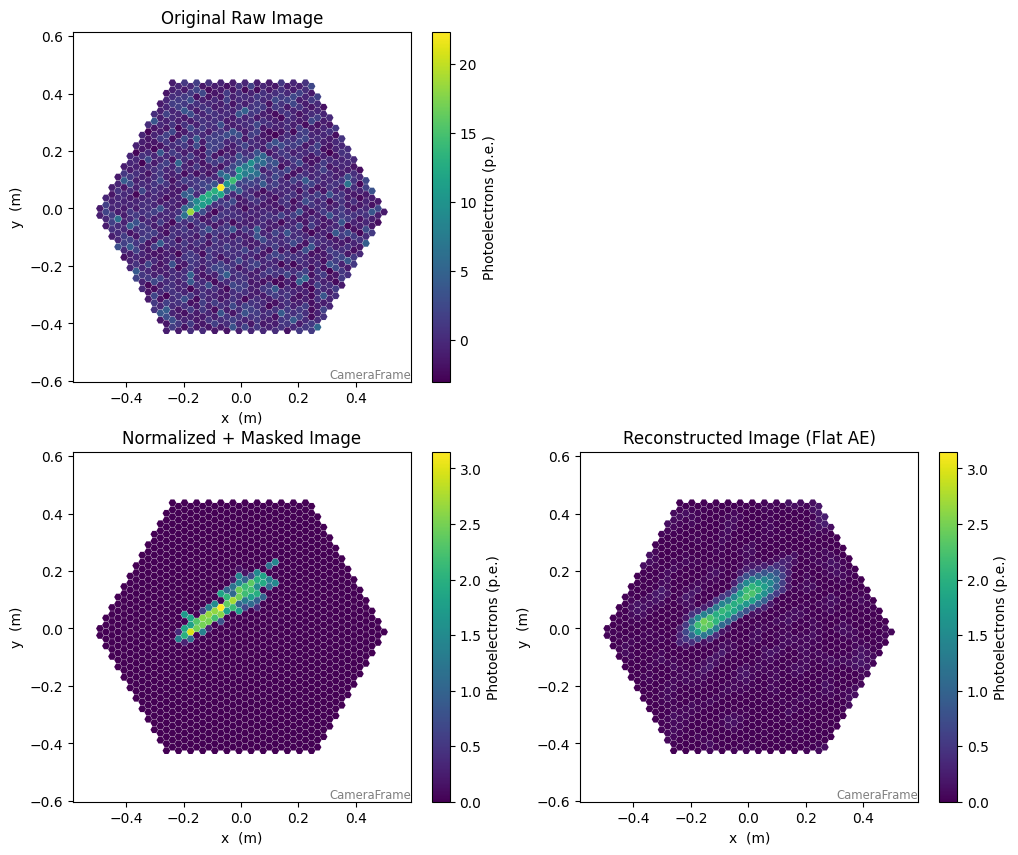

Image min (original): tensor(0.) max: tensor(3.1507)
Image min (reconstructed): tensor(-0.4373) max: tensor(2.4657)


In [14]:
idx = 13

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

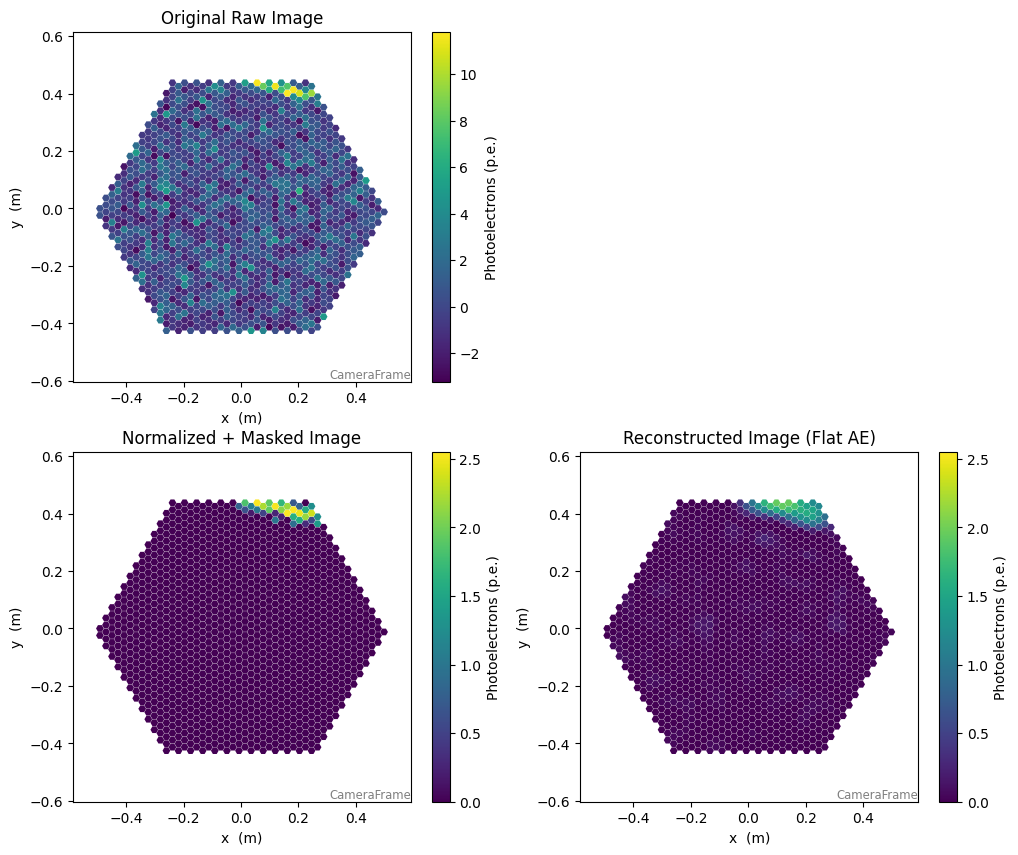

Image min (original): tensor(0.) max: tensor(2.5521)
Image min (reconstructed): tensor(-0.3038) max: tensor(1.9513)


In [15]:
idx = 4

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)

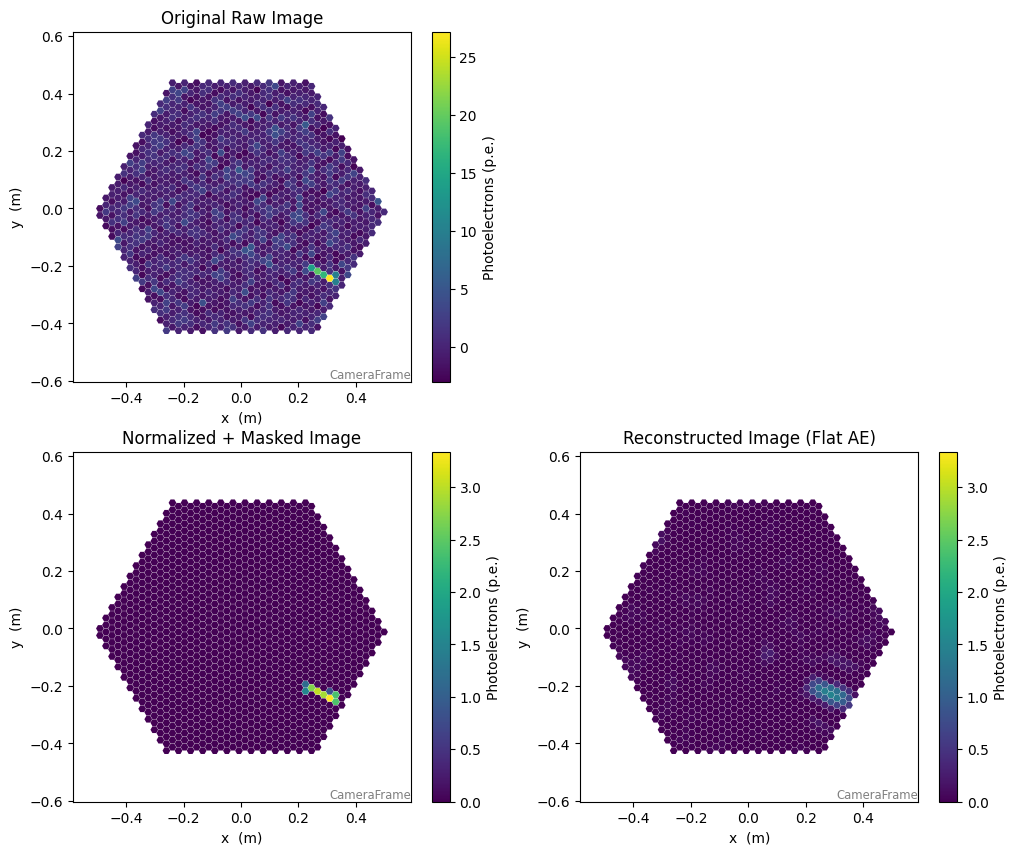

Image min (original): tensor(0.) max: tensor(3.3391)
Image min (reconstructed): tensor(-0.3552) max: tensor(1.4961)


In [16]:
idx = 9

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)

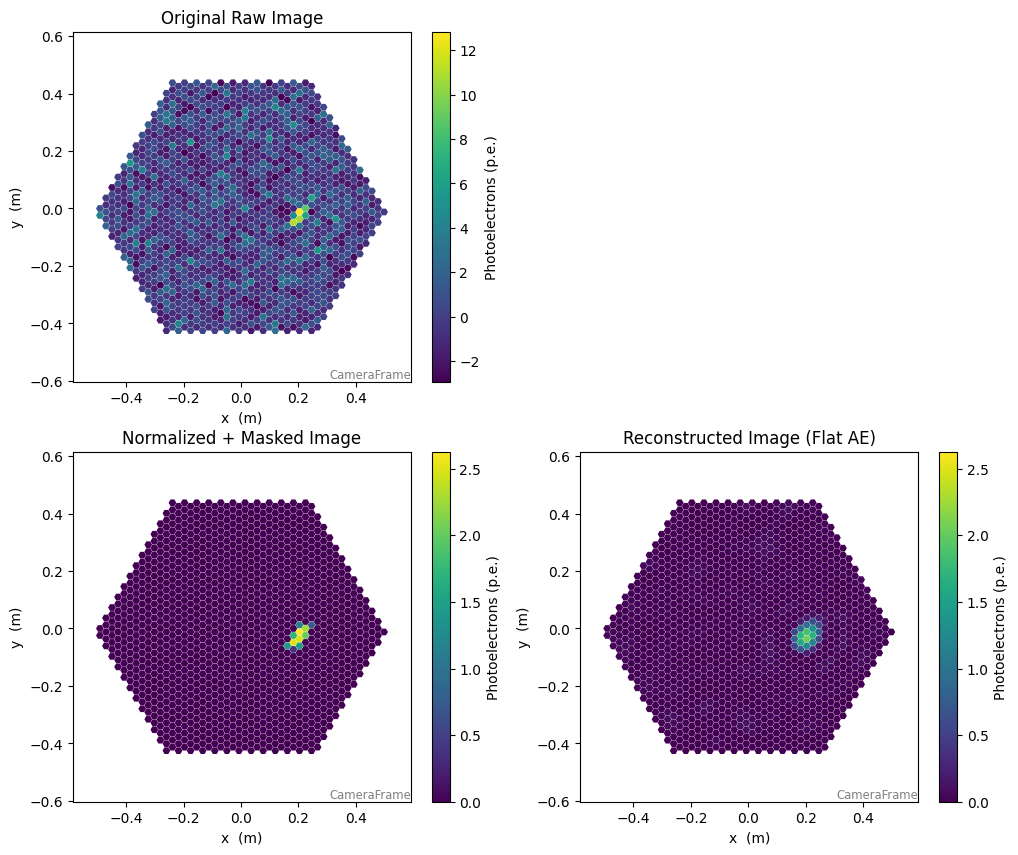

Image min (original): tensor(0.) max: tensor(2.6275)
Image min (reconstructed): tensor(-0.2664) max: tensor(2.0485)


In [17]:
idx = 19

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)